In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
import torch_geometric.datasets as datasets
from torch_geometric.data import Data

/home/hhchung/dyngraph-uda/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from dataset import load_nc_dataset

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [5]:
from alibi_detect.cd import MMDDrift

In [6]:
class GraphSAGEProjector(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, out_dim)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.conv2(x, edge_index)
        return x

@torch.no_grad()
def embed(model, data):
    model.eval()
    out = model(data)
    return out

In [7]:
def get_data(data_dir, dataset, sub_dataset=None):
    ### Load and preprocess data ###
    if dataset == 'elliptic':
        data = load_nc_dataset(data_dir, 'elliptic', sub_dataset)
    else:
        raise ValueError('Invalid dataname')
    return data

In [8]:
data_dir = '/home/hhchung/data/graph-data/elliptic_bitcoin_dataset'

In [9]:
elliptic_0_9 = [get_data(data_dir, 'elliptic', i) for i in range(9)]
elliptic_9_14 = [get_data(data_dir, 'elliptic', i) for i in range(9,14)]
elliptic_14_19 = [get_data(data_dir, 'elliptic', i) for i in range(14,19)]
elliptic_19_24 = [get_data(data_dir, 'elliptic', i) for i in range(19,24)]
elliptic_24_29 = [get_data(data_dir, 'elliptic', i) for i in range(24,29)]
elliptic_29_34 = [get_data(data_dir, 'elliptic', i) for i in range(29,34)]
elliptic_34_39 = [get_data(data_dir, 'elliptic', i) for i in range(34,39)]
elliptic_39_44 = [get_data(data_dir, 'elliptic', i) for i in range(39,44)]
elliptic_44_49 = [get_data(data_dir, 'elliptic', i) for i in range(44,49)]

/home/hhchung/dyngraph-uda/elliptic/dataset.py:75: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  edge_index = torch.tensor(A.nonzero(), dtype=torch.long)


In [10]:
elliptic_0 = get_data(data_dir, 'elliptic', 0)
num_node_features = elliptic_0.x.shape[1]
model = GraphSAGEProjector(in_dim = num_node_features,
                           hidden_dim = num_node_features // 2,
                           out_dim = num_node_features // 4)
for p in model.parameters():
    if p.dim() > 1:
        nn.init.normal_(p)

In [11]:
elliptic_0_9_emb = torch.cat([embed(model, data) for data in elliptic_0_9], dim=0)
elliptic_9_14_emb = torch.cat([embed(model, data) for data in elliptic_9_14], dim=0)
elliptic_14_19_emb = torch.cat([embed(model, data) for data in elliptic_14_19], dim=0)
elliptic_19_24_emb = torch.cat([embed(model, data) for data in elliptic_19_24], dim=0)
elliptic_24_29_emb = torch.cat([embed(model, data) for data in elliptic_24_29], dim=0)
elliptic_29_34_emb = torch.cat([embed(model, data) for data in elliptic_29_34], dim=0)
elliptic_34_39_emb = torch.cat([embed(model, data) for data in elliptic_34_39], dim=0)
elliptic_39_44_emb = torch.cat([embed(model, data) for data in elliptic_39_44], dim=0)
elliptic_44_49_emb = torch.cat([embed(model, data) for data in elliptic_44_49], dim=0)

In [12]:
elliptic_0_9_emb_sample = elliptic_0_9_emb[torch.randint(elliptic_0_9_emb.shape[0], (1000,))].detach().numpy()
elliptic_9_14_emb_sample = elliptic_9_14_emb[torch.randint(elliptic_9_14_emb.shape[0], (1000,))].detach().numpy()
elliptic_14_19_emb_sample = elliptic_14_19_emb[torch.randint(elliptic_14_19_emb.shape[0], (1000,))].detach().numpy()
elliptic_19_24_emb_sample = elliptic_19_24_emb[torch.randint(elliptic_19_24_emb.shape[0], (1000,))].detach().numpy()
elliptic_24_29_emb_sample = elliptic_24_29_emb[torch.randint(elliptic_24_29_emb.shape[0], (1000,))].detach().numpy()
elliptic_29_34_emb_sample = elliptic_29_34_emb[torch.randint(elliptic_29_34_emb.shape[0], (1000,))].detach().numpy()
elliptic_34_39_emb_sample = elliptic_34_39_emb[torch.randint(elliptic_34_39_emb.shape[0], (1000,))].detach().numpy()
elliptic_39_44_emb_sample = elliptic_39_44_emb[torch.randint(elliptic_39_44_emb.shape[0], (1000,))].detach().numpy()
elliptic_44_49_emb_sample = elliptic_44_49_emb[torch.randint(elliptic_44_49_emb.shape[0], (1000,))].detach().numpy()

In [25]:
from typing import List
def pca_plot(sample_list: List[np.ndarray], label: List[str]):
    color_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple', 'tab:pink', 'tab:olive', 'tab:cyan']
    assert len(sample_list) <= len(color_list)
    sample_num_list = [sample.shape[0] for sample in sample_list]
    sample_list = np.concatenate(sample_list, axis=0)
    pca = PCA(n_components=2)
    print("Fitting pca")
    pca.fit(sample_list)
    sample_list = pca.transform(sample_list)
    
    fig, ax = plt.subplots(1)
    acc_num = 0
    
    for i, num in enumerate(sample_num_list):
        ax.scatter(sample_list[acc_num:acc_num+num, 0], sample_list[acc_num:acc_num+num, 1], c=color_list[i], label=label[i])
        acc_num += num
    ax.legend()
    fig.savefig("nodescatter.png", dpi=400)
    

Fitting pca


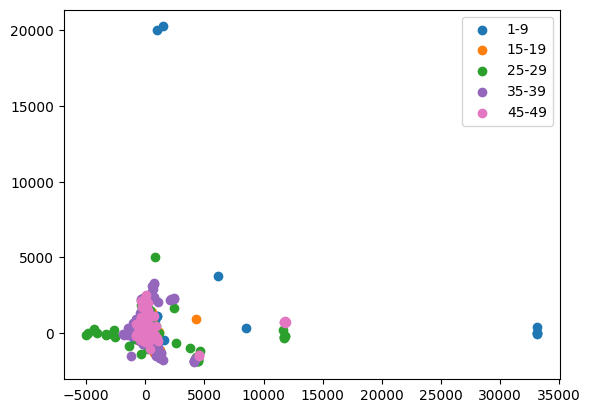

In [26]:
sample_list = [elliptic_0_9_emb_sample, elliptic_14_19_emb_sample, elliptic_24_29_emb_sample, elliptic_34_39_emb_sample, elliptic_44_49_emb_sample]
pca_plot(sample_list, label=['1-9', '15-19', '25-29', '35-39', '45-49'])

In [15]:
cd = MMDDrift(elliptic_0_9_emb_sample, backend='pytorch', p_val=.05)


In [16]:
preds = cd.predict(elliptic_0_9_emb[torch.randint(elliptic_0_9_emb.shape[0], (1000,))].detach().numpy(), return_p_val=True, return_distance=True)
print('Drift?', bool(preds['data']['is_drift']), 'MMD^2:', preds['data']['distance'], 'p-val', preds['data']['p_val'])

Drift? False MMD^2: 0.0003337264060974121 p-val 0.14000000059604645


In [17]:
preds = cd.predict(elliptic_9_14_emb_sample, return_p_val=True, return_distance=True)
print('Drift?', bool(preds['data']['is_drift']), 'MMD^2:', preds['data']['distance'], 'p-val', preds['data']['p_val'])

Drift? True MMD^2: 0.011447548866271973 p-val 0.0


In [18]:
preds = cd.predict(elliptic_14_19_emb_sample, return_p_val=True, return_distance=True)
print('Drift?', bool(preds['data']['is_drift']), 'MMD^2:', preds['data']['distance'], 'p-val', preds['data']['p_val'])

Drift? True MMD^2: 0.01737159490585327 p-val 0.0


In [19]:
preds = cd.predict(elliptic_19_24_emb_sample, return_p_val=True, return_distance=True)
print('Drift?', bool(preds['data']['is_drift']), 'MMD^2:', preds['data']['distance'], 'p-val', preds['data']['p_val'])

Drift? True MMD^2: 0.025463461875915527 p-val 0.0


In [20]:
preds = cd.predict(elliptic_24_29_emb_sample, return_p_val=True, return_distance=True)
print('Drift?', bool(preds['data']['is_drift']), 'MMD^2:', preds['data']['distance'], 'p-val', preds['data']['p_val'])

Drift? True MMD^2: 0.03571760654449463 p-val 0.0


In [21]:
preds = cd.predict(elliptic_29_34_emb_sample, return_p_val=True, return_distance=True)
print('Drift?', bool(preds['data']['is_drift']), 'MMD^2:', preds['data']['distance'], 'p-val', preds['data']['p_val'])

Drift? True MMD^2: 0.06187903881072998 p-val 0.0


In [22]:
preds = cd.predict(elliptic_34_39_emb_sample, return_p_val=True, return_distance=True)
print('Drift?', bool(preds['data']['is_drift']), 'MMD^2:', preds['data']['distance'], 'p-val', preds['data']['p_val'])

Drift? True MMD^2: 0.07301890850067139 p-val 0.0


In [23]:
preds = cd.predict(elliptic_39_44_emb_sample, return_p_val=True, return_distance=True)
print('Drift?', bool(preds['data']['is_drift']), 'MMD^2:', preds['data']['distance'], 'p-val', preds['data']['p_val'])

Drift? True MMD^2: 0.08303546905517578 p-val 0.0


In [24]:
preds = cd.predict(elliptic_44_49_emb_sample, return_p_val=True, return_distance=True)
print('Drift?', bool(preds['data']['is_drift']), 'MMD^2:', preds['data']['distance'], 'p-val', preds['data']['p_val'])

Drift? True MMD^2: 0.09810835123062134 p-val 0.0
